# ML Project 2 – Milestone 1

## Authors
- **Antoni Rakowski**
- **Michał Syriewicz**


In [19]:
import os
import shutil
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.cluster import (KMeans, DBSCAN, AgglomerativeClustering, 
                           SpectralClustering, AffinityPropagation, 
                           MeanShift, OPTICS, Birch)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, davies_bouldin_score, 
                           calinski_harabasz_score)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.neighbors
from sklearn.cluster import estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy.stats import entropy, skew, kurtosis
from skimage.filters import sobel, prewitt
from skimage.measure import shannon_entropy
import shap
import lime
import lime.lime_tabular
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans


In [8]:
base_dir = "clean_data"

In [13]:

def extract_features(image_path):
    # 1. Wczytaj obraz jako szarość (0-255)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # Ujednolicenie rozmiaru

    # 2. Histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    hist = hist / hist.sum()

    # 3. Statystyki podstawowe
    mean_val = np.mean(img)
    std_val = np.std(img)
    var_val = np.var(img)
    skewness = skew(img.flatten())
    kurt = kurtosis(img.flatten())

    # --- zamiast GLCM: proste cechy tekstury z gradientów ---

    # Sobel - krawędzie
    sobel_edges = sobel(img)
    sobel_mean = np.mean(sobel_edges)
    sobel_std = np.std(sobel_edges)
    sobel_max = np.max(sobel_edges)

    # Prewitt - alternatywna metoda krawędziowa
    prewitt_edges = prewitt(img)
    prewitt_mean = np.mean(prewitt_edges)
    prewitt_std = np.std(prewitt_edges)
    prewitt_max = np.max(prewitt_edges)

    # 6. Cecha Laplace'a (detekcja punktów ostrości)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian_var = np.var(laplacian)

    # 7. Entropia obrazu
    eps = 1e-10  # żeby uniknąć log(0)
    entropy = -np.sum(hist * np.log2(hist + eps))

    # 8. Cechy jasności
    min_val = np.min(img)
    max_val = np.max(img)
    median_val = np.median(img)

    # Zwracamy 20 cech:
    return [
        mean_val, std_val, var_val, skewness, kurt,
        sobel_mean, sobel_std, sobel_max,
        prewitt_mean, prewitt_std, prewitt_max,
        laplacian_var, entropy,
        min_val, max_val, median_val,
        hist[0], hist[64], hist[128], hist[255]
    ]


In [14]:
paths = glob(os.path.join(base_dir, "*"))


all_features = []
for path in paths:
    feats = extract_features(path)
    if feats is None:
        print(f"Nie można wczytać obrazu: {path}")
        continue
    all_features.append(feats)

print(f"Liczba przetworzonych obrazów: {len(all_features)}")
print(f"Przykładowe cechy pierwszego obrazu:\n{all_features[0]}")

Liczba przetworzonych obrazów: 5228
Przykładowe cechy pierwszego obrazu:
[np.float64(187.86354064941406), np.float64(47.27481487430013), np.float64(2234.9081213993486), np.float64(-0.6345191381154751), np.float64(-0.05464123872375648), np.float64(0.012336025287375455), np.float64(0.0166834958901041), np.float64(0.38453625010291836), np.float64(0.012223146883692887), np.float64(0.016447225793178734), np.float64(0.36240282975282945), np.float64(25.598681648960337), np.float32(7.109968), np.uint8(28), np.uint8(251), np.float64(190.0), np.float32(0.0), np.float32(0.00039672852), np.float32(0.0028839111), np.float32(0.0)]


Metoda: KMeans
Liczba klastrów: 3


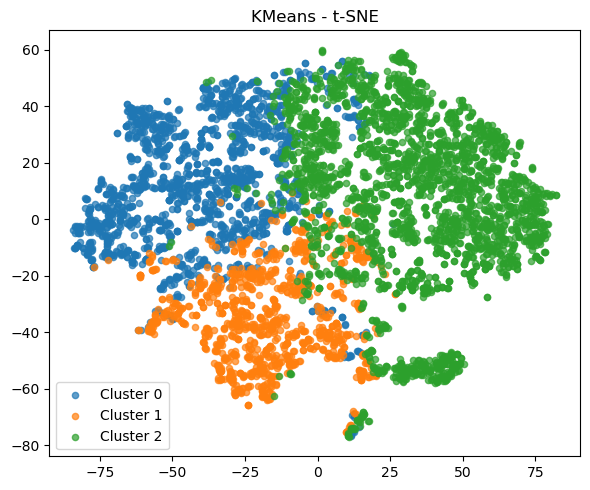

Metoda: Agglomerative
Liczba klastrów: 3


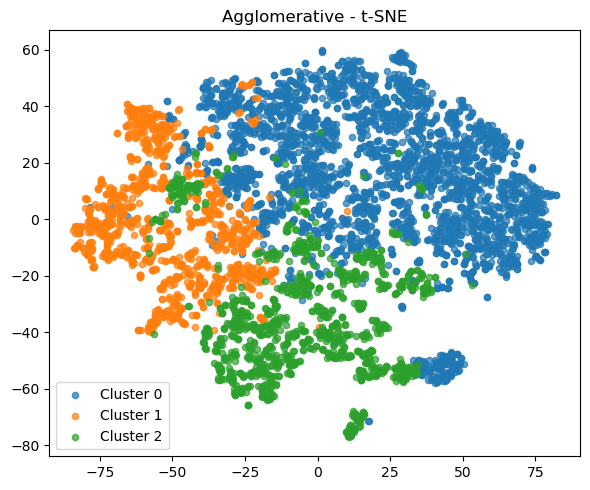

Metoda: DBSCAN
Liczba klastrów: 1


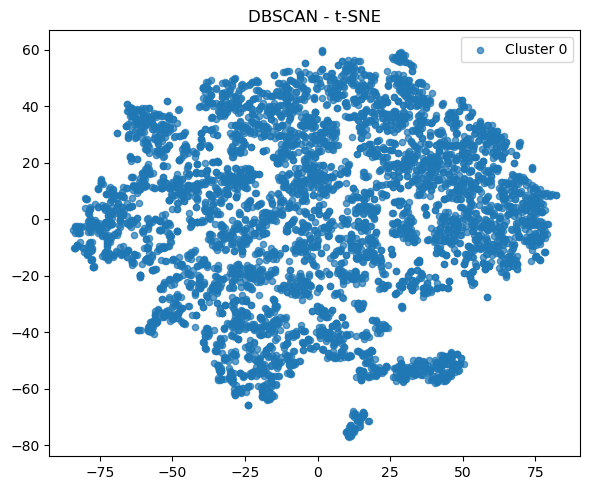

Metoda: BIRCH
Liczba klastrów: 3


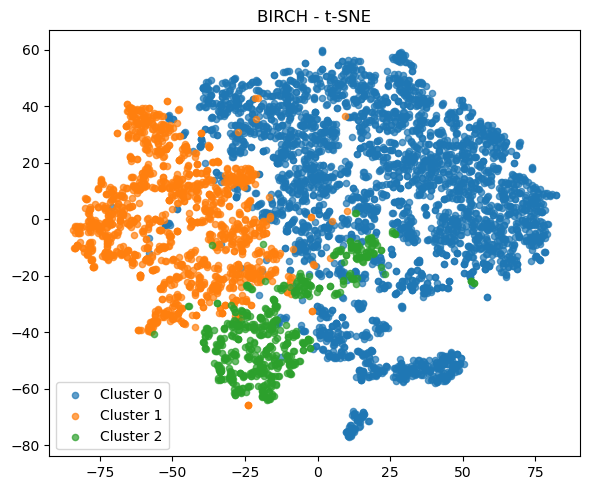

Metoda: MeanShift
Liczba klastrów: 16


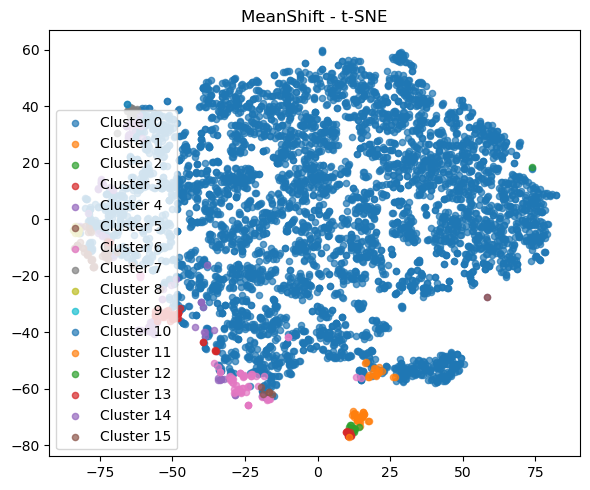

Metoda: GMM
Liczba klastrów: 3


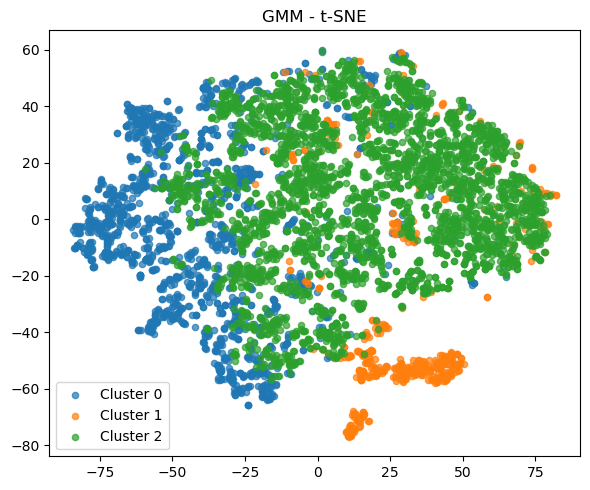

Metoda: MiniBatchKMeans
Liczba klastrów: 3


c:\Users\micae\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


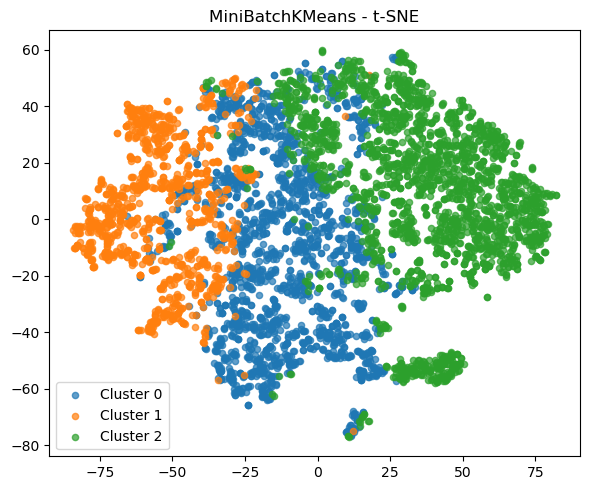

In [23]:
X = np.array(all_features)

# Skalowanie
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Funkcja do rysowania
def plot_clusters(X_red, labels, title):
    plt.figure(figsize=(6,5))
    unique_labels = np.unique(labels)
    for lbl in unique_labels:
        if lbl == -1:
            color = 'k'
            label = 'Noise'
        else:
            color = plt.cm.tab10(lbl % 10)
            label = f'Cluster {lbl}'
        plt.scatter(X_red[labels == lbl, 0], X_red[labels == lbl, 1], 
                    c=[color], label=label, s=20, alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Modele klastrowania
cluster_models = {
    "KMeans": KMeans(n_clusters=3, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=20, min_samples=3),
    "BIRCH": Birch(n_clusters=3),
    "MeanShift": MeanShift(),
    "GMM": GaussianMixture(n_components=3, random_state=42),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=3, random_state=42)
}

for name, model in cluster_models.items():
    print(f"Metoda: {name}")
    if name == "GMM":
        labels = model.fit_predict(X_scaled)
    else:
        labels = model.fit_predict(X_scaled)
    print(f"Liczba klastrów: {len(np.unique(labels))}")

    # Liczymy t-SNE tylko dla tego modelu, by od razu mieć redukcję do rysowania
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_scaled)

    plot_clusters(X_tsne, labels, f"{name} - t-SNE")

**Spliting data into train, test and validation** 

In [24]:
paths = glob(os.path.join(base_dir, "*"))
train_val_paths, test_paths = train_test_split(paths, test_size=0.3, random_state=42)
train_paths, val_paths = train_test_split(train_val_paths, test_size=0.3, random_state=42)

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")
print(f"Test set size: {len(test_paths)}") 

os.makedirs("train_data", exist_ok=True)
os.makedirs("val_data", exist_ok=True)
os.makedirs("test_data", exist_ok=True)

for path in train_paths:
    shutil.copy2(path, os.path.join("train_data", os.path.basename(path)))

for path in val_paths:
    shutil.copy2(path, os.path.join("val_data", os.path.basename(path)))

for path in test_paths: 
    shutil.copy2(path, os.path.join("test_data", os.path.basename(path)))


Training set size: 2561
Validation set size: 1098
Test set size: 1569



**Extracting data from photos**

In [25]:
pixel_data = []
brightness_data = []
contrast_data = []
edge_density_data = []
entropy_data = []
data_dir = "train_data"
paths = glob(os.path.join(data_dir, "*"))

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    flat = img.flatten()
    if len(flat) != 42387 :
        print("O cholibka!")
        print(path)
        print(len(flat))
        
   
    pixel_data.extend(flat)
    brightness_data.append(np.mean(flat))
    contrast_data.append(np.std(flat))

    edge_map = sobel(img)
    edge_density_data.append(np.mean(edge_map))
    entropy_data.append(shannon_entropy(img))

pixel_data = np.array(pixel_data)

**Ploting some of the features**

In [26]:
def plot_three_histograms(data_list, title, xlabel, bins=50):
    plt.figure(figsize=(18, 4))

    plt.hist(data_list, bins=bins, color='gray', alpha=0.85)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    


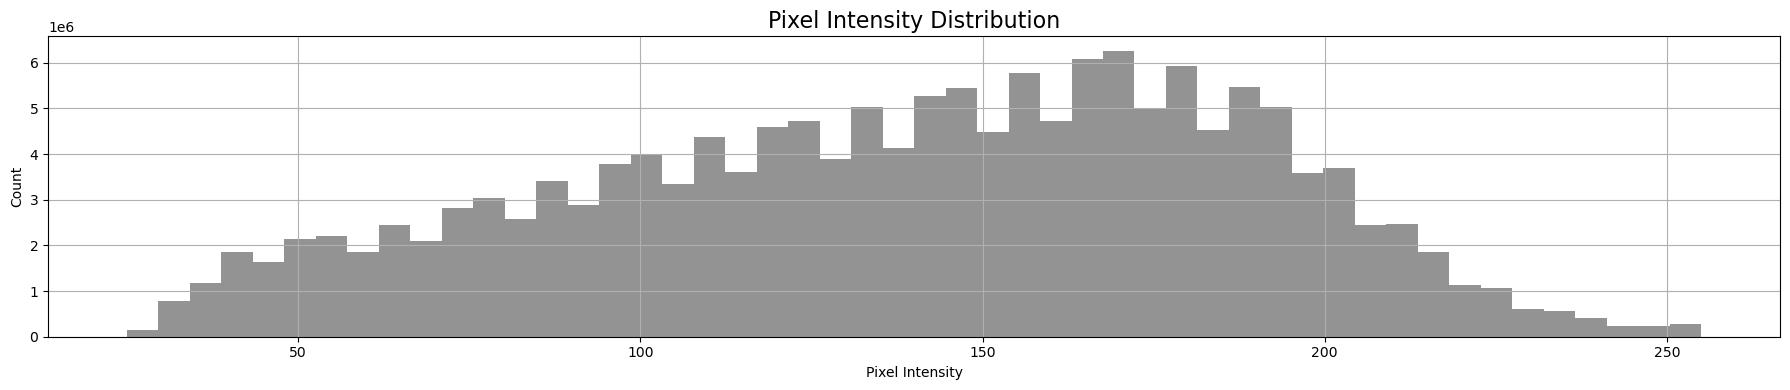

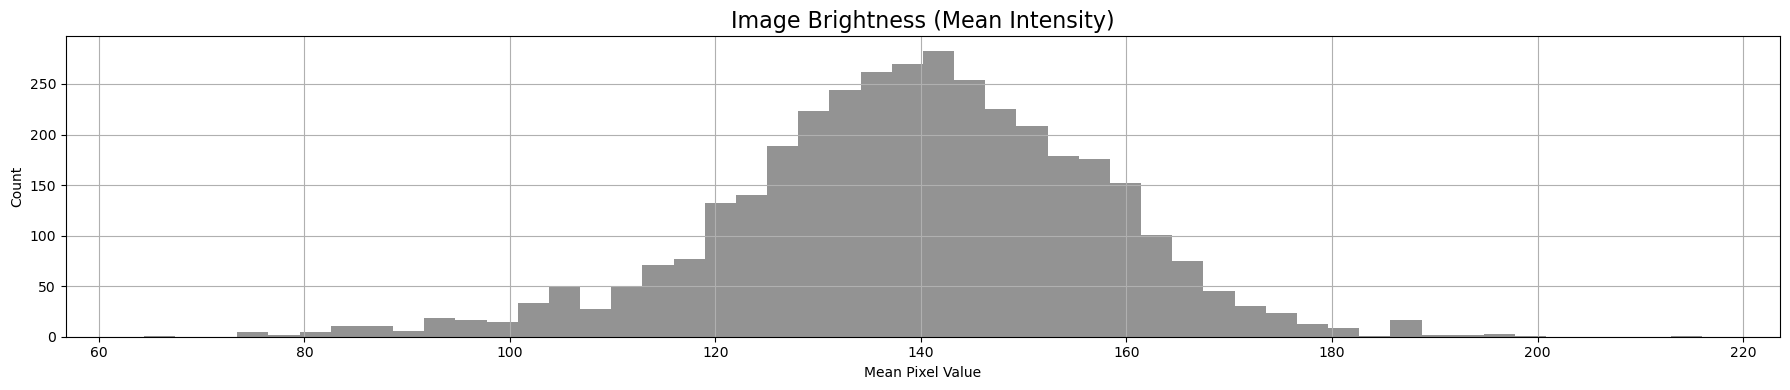

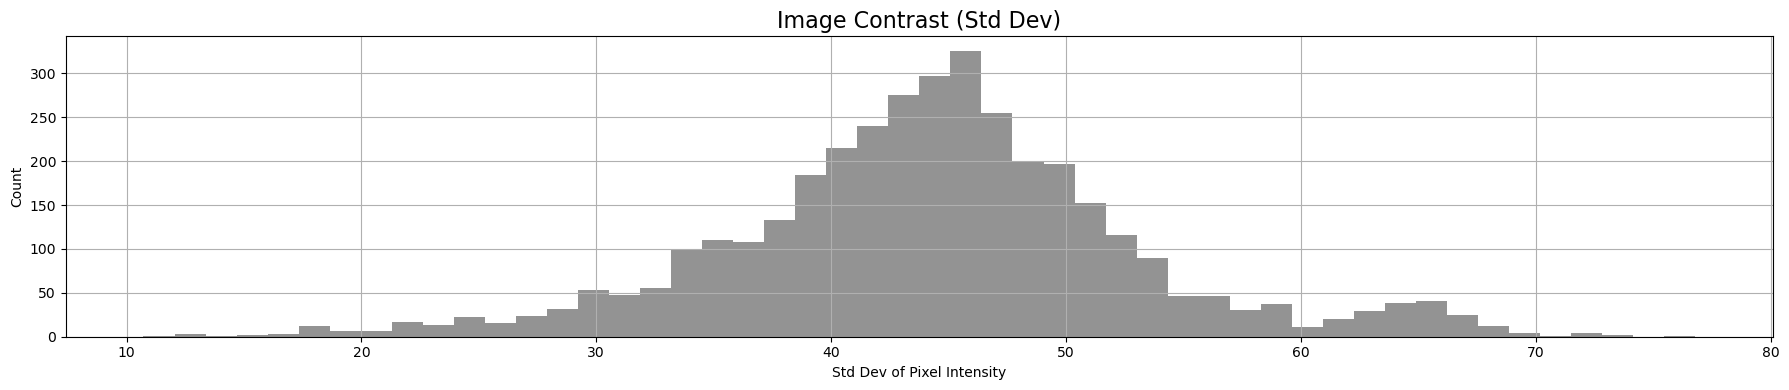

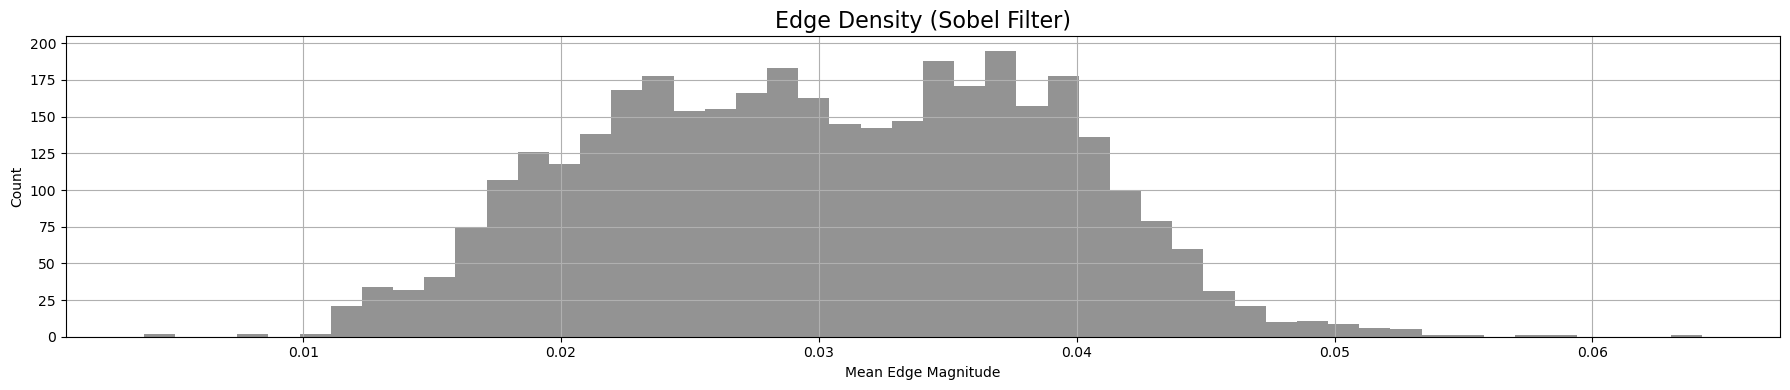

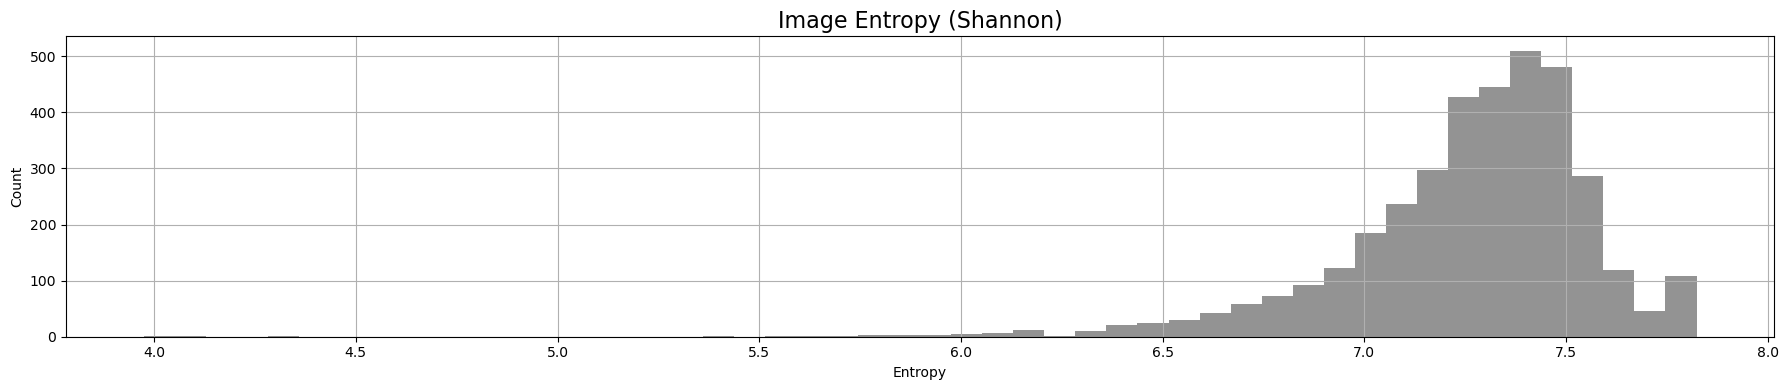

In [ ]:
# 1. Pixel Intensity Histogram (all pixels across all images)
plot_three_histograms(pixel_data, "Pixel Intensity Distribution", "Pixel Intensity")

# 2. Brightness per Image
plot_three_histograms(brightness_data, "Image Brightness (Mean Intensity)", "Mean Pixel Value")

# 3. Contrast per Image
plot_three_histograms(contrast_data, "Image Contrast (Std Dev)", "Std Dev of Pixel Intensity")

# 4. Edge Density per Image
plot_three_histograms(edge_density_data, "Edge Density (Sobel Filter)", "Mean Edge Magnitude")

#5. Shannon Entropy
plot_three_histograms(entropy_data, "Image Entropy (Shannon)", "Entropy")


# Important! <br>
**You may need to change first value in reshape function if you have different amount of phots in your directory**

In [28]:
pixel_data=pixel_data.reshape(3659,42387)



In [29]:
entropy_data=np.array(entropy_data).reshape(-1,1)
edge_density_data=np.array(edge_density_data).reshape(-1,1)
contrast_data=np.array(contrast_data).reshape(-1,1)
brightness_data=np.array(brightness_data).reshape(-1,1)


In [30]:
pixel_data_all=np.concatenate((pixel_data, entropy_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, edge_density_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, contrast_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, brightness_data), axis=1)
pixel_data_all.shape

(3659, 42391)

**First clustering models**

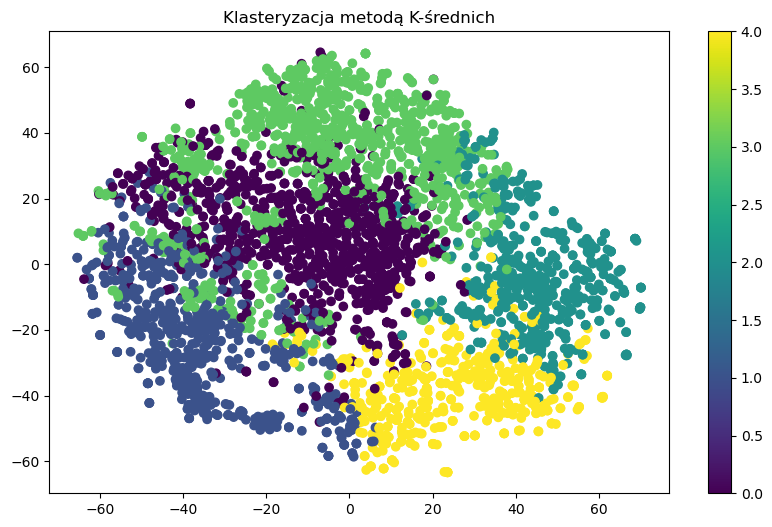


Metryki oceny dla K-średnich:
Współczynnik Silhouette: 0.087
Współczynnik Daviesa-Bouldina: 2.646
Współczynnik Calinskiego-Harabasza: 399.079


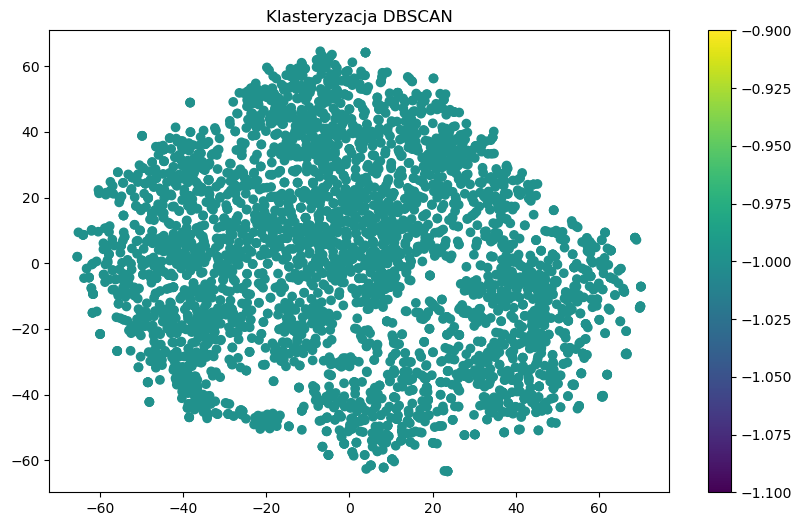


Uwaga: DBSCAN utworzył tylko jeden klaster - nie można obliczyć metryk


In [31]:
scaled_data = pixel_data_all
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
def plot_clustering_results(tsne_data, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

def evaluate_clustering(data, labels, model_name):
    if len(np.unique(labels)) > 1:  
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        
        print(f"\nMetryki oceny dla {model_name}:")
        print(f"Współczynnik Silhouette: {sil_score:.3f}")
        print(f"Współczynnik Daviesa-Bouldina: {db_score:.3f}")
        print(f"Współczynnik Calinskiego-Harabasza: {ch_score:.3f}")
    else:
        print(f"\nUwaga: {model_name} utworzył tylko jeden klaster - nie można obliczyć metryk")

# 1. Klasteryzacja metodą K-średnich

n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

plot_clustering_results(tsne_results, kmeans_labels, 'Klasteryzacja metodą K-średnich')
evaluate_clustering(scaled_data, kmeans_labels, 'K-średnich')


# 2. Klasteryzacja DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5) 
dbscan_labels = dbscan.fit_predict(scaled_data)

plot_clustering_results(tsne_results, dbscan_labels, 'Klasteryzacja DBSCAN')
evaluate_clustering(scaled_data, dbscan_labels, 'DBSCAN')




Using ResNet50 to try to extract better and smaller number of features in order to run more sophisticated models

In [32]:


model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1]) 
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


embeddings = []
filenames = []
image_files = [f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
for filename in tqdm(image_files, desc="Przetwarzanie obrazów"):
    img_path = os.path.join(data_dir, filename)
    try:
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)
    
        with torch.no_grad():
            embedding = model(x).squeeze().numpy()
            embeddings.append(embedding)
            filenames.append(filename)
            
    except Exception as e:
        print(f"Błąd podczas przetwarzania {filename}: {e}")

embeddings_array = np.array(embeddings)
print("Kształt tablicy z cechami:", embeddings_array.shape)
print("Liczba przetworzonych obrazów:", len(filenames))

c:\Users\micae\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micae\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Przetwarzanie obrazów: 100%|██████████| 3659/3659 [03:26<00:00, 17.69it/s]

Kształt tablicy z cechami: (3659, 2048)
Liczba przetworzonych obrazów: 3659


In [33]:
embeddings_array2=np.concatenate((embeddings_array, entropy_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, edge_density_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, contrast_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, brightness_data), axis=1)
embeddings_array2.shape

(3659, 2052)

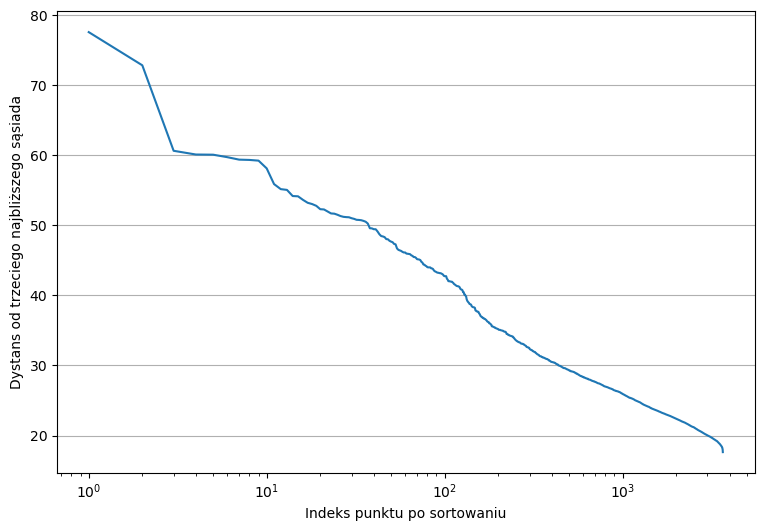

In [35]:
minPts = 1000
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(embeddings_array2)
distances, indices = nbrs.kneighbors(embeddings_array2)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,embeddings_array2.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

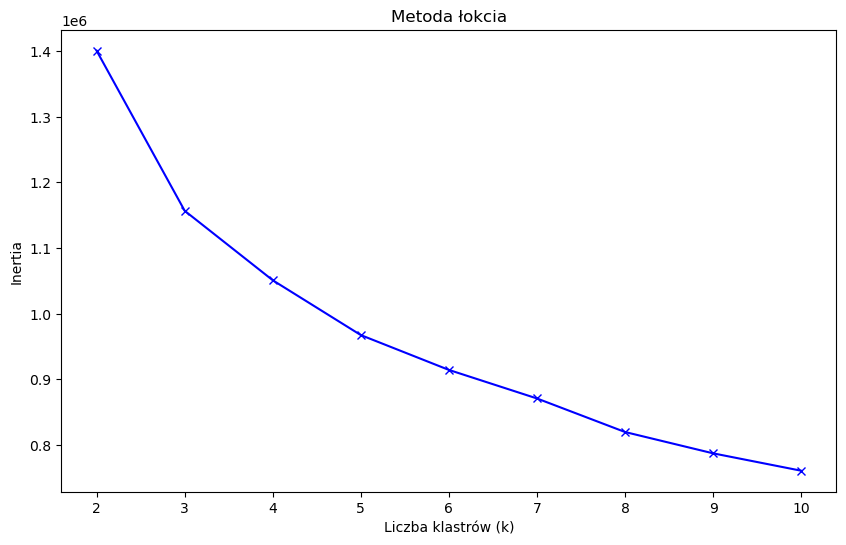

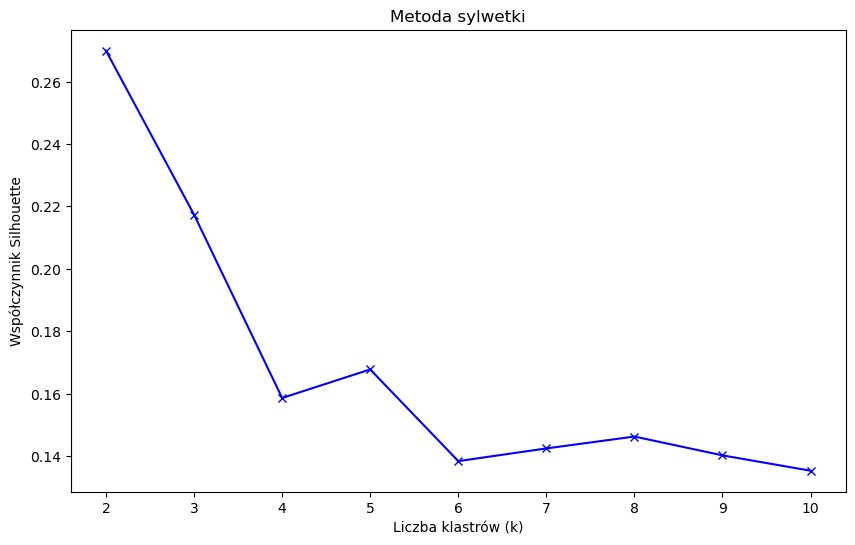

In [36]:

inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(embeddings_array2)
    inertias.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia')
plt.title('Metoda łokcia')
plt.show()

# Metoda sylwetki
silhouette_scores = []
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_test.fit_predict(embeddings_array2)
    silhouette_scores.append(silhouette_score(embeddings_array2, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Współczynnik Silhouette')
plt.title('Metoda sylwetki')
plt.show()

# Clustering with new features using also more complex models

In [37]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(embeddings_array2)
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
def plot_clustering_results_3d(tsne_data, labels, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=tsne_data[:, 0],
        y=tsne_data[:, 1],
        z=tsne_data[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            showscale=True
        )
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='TSNE 1',
            yaxis_title='TSNE 2',
            zaxis_title='TSNE 3'
        ),
        width=1000,
        height=600
    )
    fig.show()

def evaluate_clustering_and_show_examples(data, labels, model_name, folder_path, num_examples=20):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_paths = [os.path.join(folder_path, f) for f in image_files]
    
    if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        
        print(f"\nMetryki oceny dla {model_name}:")
        print(f"Współczynnik Silhouette: {sil_score:.3f}")
        print(f"Współczynnik Daviesa-Bouldina: {db_score:.3f}")
        print(f"Współczynnik Calinskiego-Harabasza: {ch_score:.3f}")

        unique_labels = np.unique(labels)
        for label in unique_labels:
            cluster_indices = np.where(labels == label)[0]
            cluster_files = [image_files[i] for i in cluster_indices]

            covid_count = sum('COVID' in f for f in cluster_files)
            pneumonia_count = sum('PNEUMONIA' in f for f in cluster_files)
            normal_count = sum('NORMAL' in f for f in cluster_files)
            total = len(cluster_files)
            
            print(f"\nKlaster {label}:")
            print(f"Liczba obrazów w klastrze: {total}")
            print(f"COVID: {covid_count/total*100:.1f}%")
            print(f"PNEUMONIA: {pneumonia_count/total*100:.1f}%")
            print(f"NORMAL: {normal_count/total*100:.1f}%")
    else:
        print(f"\nUwaga: {model_name} utworzył tylko jeden klaster - nie można obliczyć metryk")

# 1. Klasteryzacja metodą K-średnich
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, kmeans_labels, 'Klasteryzacja metodą K-średnich')
evaluate_clustering_and_show_examples(scaled_data, kmeans_labels, 'K-średnich', data_dir)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, gmm_labels, 'Klasteryzacja metodą Gaussian Mixture')
evaluate_clustering_and_show_examples(scaled_data, gmm_labels, 'Gaussian Mixture', data_dir)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, agg_labels, 'Klasteryzacja hierarchiczna')
evaluate_clustering_and_show_examples(scaled_data, agg_labels, 'Agglomerative Clustering', data_dir)
# Birch
birch = Birch(threshold=0.2)
birch_labels = birch.fit_predict(scaled_data)

cluster_1 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 0]
cluster_2 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 1]
cluster_3 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 2]

plot_clustering_results_3d(tsne_results, birch_labels, 'Klasteryzacja metodą Birch')
evaluate_clustering_and_show_examples(scaled_data, birch_labels, 'Birch', data_dir)





Metryki oceny dla K-średnich:
Współczynnik Silhouette: 0.085
Współczynnik Daviesa-Bouldina: 2.946
Współczynnik Calinskiego-Harabasza: 436.125

Klaster 0:
Liczba obrazów w klastrze: 1129
COVID: 1.1%
PNEUMONIA: 27.5%
NORMAL: 71.4%

Klaster 1:
Liczba obrazów w klastrze: 1432
COVID: 3.1%
PNEUMONIA: 64.9%
NORMAL: 31.9%

Klaster 2:
Liczba obrazów w klastrze: 1098
COVID: 96.3%
PNEUMONIA: 1.7%
NORMAL: 2.0%



Metryki oceny dla Gaussian Mixture:
Współczynnik Silhouette: 0.085
Współczynnik Daviesa-Bouldina: 2.946
Współczynnik Calinskiego-Harabasza: 436.125

Klaster 0:
Liczba obrazów w klastrze: 1129
COVID: 1.1%
PNEUMONIA: 27.5%
NORMAL: 71.4%

Klaster 1:
Liczba obrazów w klastrze: 1432
COVID: 3.1%
PNEUMONIA: 64.9%
NORMAL: 31.9%

Klaster 2:
Liczba obrazów w klastrze: 1098
COVID: 96.3%
PNEUMONIA: 1.7%
NORMAL: 2.0%



Metryki oceny dla Agglomerative Clustering:
Współczynnik Silhouette: 0.082
Współczynnik Daviesa-Bouldina: 3.115
Współczynnik Calinskiego-Harabasza: 395.064

Klaster 0:
Liczba obrazów w klastrze: 1431
COVID: 1.3%
PNEUMONIA: 17.6%
NORMAL: 81.1%

Klaster 1:
Liczba obrazów w klastrze: 1219
COVID: 89.6%
PNEUMONIA: 4.4%
NORMAL: 6.0%

Klaster 2:
Liczba obrazów w klastrze: 1009
COVID: 0.3%
PNEUMONIA: 94.5%
NORMAL: 5.2%



Metryki oceny dla Birch:
Współczynnik Silhouette: 0.081
Współczynnik Daviesa-Bouldina: 3.205
Współczynnik Calinskiego-Harabasza: 398.257

Klaster 0:
Liczba obrazów w klastrze: 1366
COVID: 3.1%
PNEUMONIA: 76.0%
NORMAL: 20.9%

Klaster 1:
Liczba obrazów w klastrze: 1086
COVID: 98.0%
PNEUMONIA: 1.1%
NORMAL: 0.9%

Klaster 2:
Liczba obrazów w klastrze: 1207
COVID: 0.7%
PNEUMONIA: 17.4%
NORMAL: 81.9%


**We are now using a simple classifier to determine feature importances and gain insights into cluster interpretation.**

Dokładność na zbiorze treningowym: 1.0000
Dokładność na zbiorze testowym: 0.9413


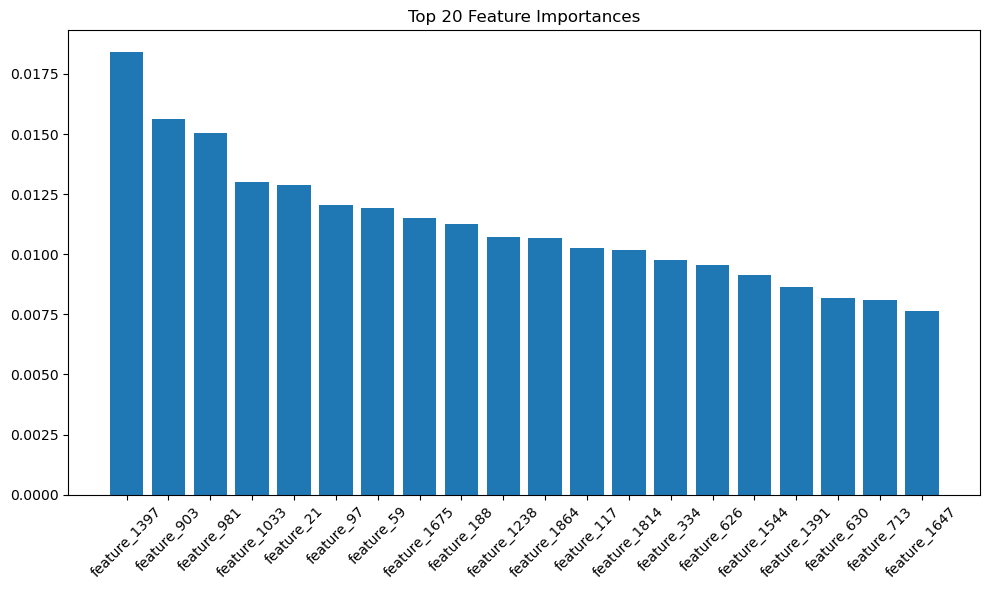

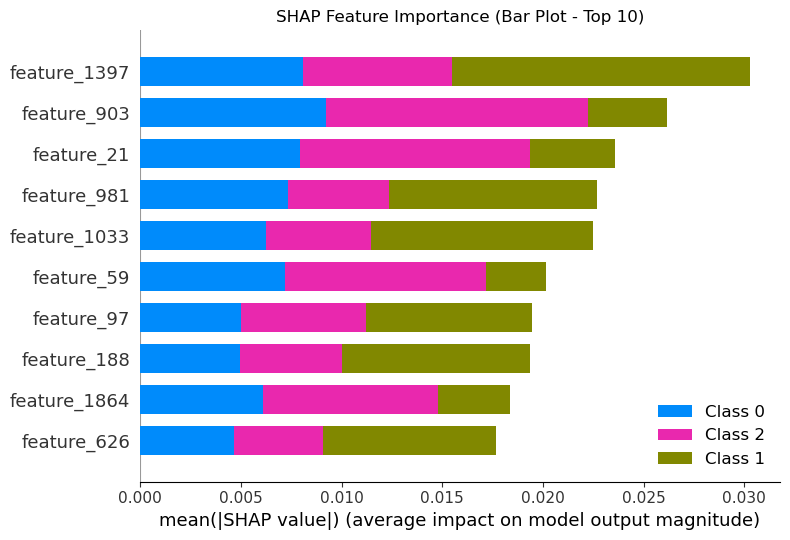

<Figure size 1500x800 with 0 Axes>

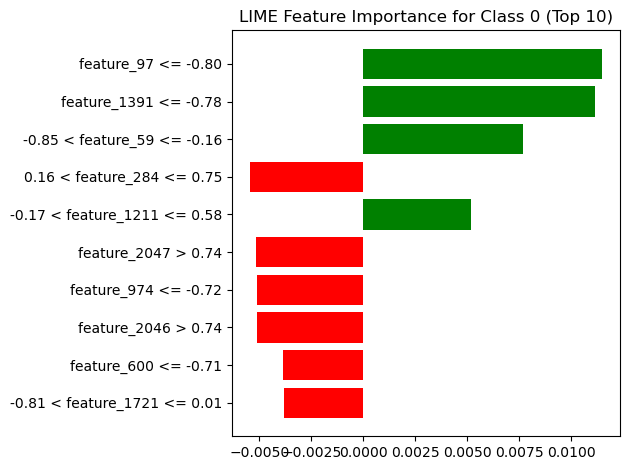

<Figure size 1500x800 with 0 Axes>

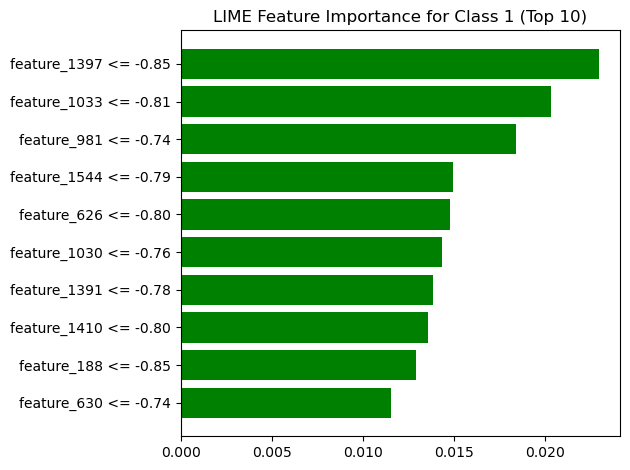

<Figure size 1500x800 with 0 Axes>

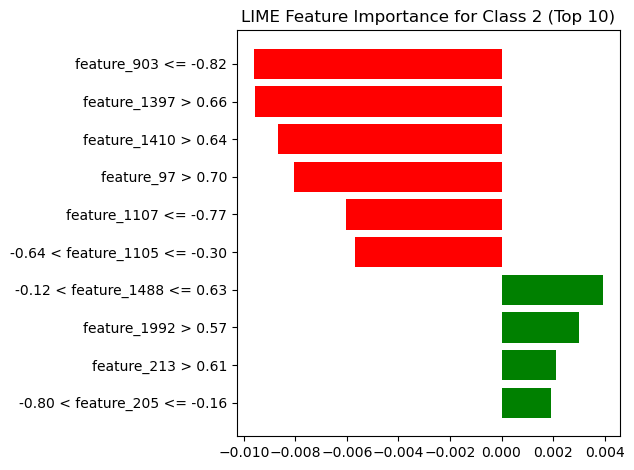

In [38]:

X = scaled_data
y = birch_labels


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"Dokładność na zbiorze treningowym: {train_score:.4f}")
print(f"Dokładność na zbiorze testowym: {test_score:.4f}")
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20] 

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices])
plt.xticks(range(20), [f'feature_{i}' for i in indices], rotation=45)
plt.tight_layout()
plt.show()
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(15, 8))
shap.summary_plot(
    shap_values, 
    X_test,
    plot_type="bar",
    feature_names=[f"feature_{i}" for i in range(X_test.shape[1])],
    show=False,
    max_display=10 
)
plt.title('SHAP Feature Importance (Bar Plot - Top 10)')
plt.tight_layout() 
plt.show()
plt.close()

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train,  
    mode="classification", 
    training_labels=y_train,
    feature_names=[f"feature_{i}" for i in range(X.shape[1])]
)

unique_classes = np.unique(y_test)

for i, class_label in enumerate(unique_classes):
    class_idx = np.where(y_test == class_label)[0][0]
    
    exp = explainer_lime.explain_instance(
        X_test[class_idx],  
        rf_model.predict_proba,
        num_features=10  
    )
    
    plt.figure(figsize=(15, 8))
    exp.as_pyplot_figure()
    plt.title(f'LIME Feature Importance for Class {class_label} (Top 10)')
    plt.tight_layout()
    plt.show()
    plt.close()